### Librerías

In [1]:
#!pip install --upgrade --no-cache-dir gdown

import os

import random
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights

from matplotlib import pyplot as plt

### Cargar imágenes y sus targets

In [2]:
# Descargar y descromprimir el dataset de imágenes de fondo de ojo.
!gdown 1Mcizi0JMfEtZE5dBzOgdOPXlUfMUCCAS
!unzip /content/preprocessed_images.zip -d ./preprocessed_images

# Descargar .csv que contiene los targets para cada imagen.
!gdown 1xe5Qzvqjzwlspm24um4sfnvY1RwL6c2h

Streaming output truncated to the last 5000 lines.
  inflating: ./preprocessed_images/preprocessed_images/2178_right.jpg  
  inflating: ./preprocessed_images/preprocessed_images/2179_left.jpg  
  inflating: ./preprocessed_images/preprocessed_images/2179_right.jpg  
  inflating: ./preprocessed_images/preprocessed_images/218_left.jpg  
  inflating: ./preprocessed_images/preprocessed_images/218_right.jpg  
  inflating: ./preprocessed_images/preprocessed_images/2180_left.jpg  
  inflating: ./preprocessed_images/preprocessed_images/2180_right.jpg  
  inflating: ./preprocessed_images/preprocessed_images/2181_left.jpg  
  inflating: ./preprocessed_images/preprocessed_images/2181_right.jpg  
  inflating: ./preprocessed_images/preprocessed_images/2182_left.jpg  
  inflating: ./preprocessed_images/preprocessed_images/2182_right.jpg  
  inflating: ./preprocessed_images/preprocessed_images/2183_left.jpg  
  inflating: ./preprocessed_images/preprocessed_images/2183_right.jpg  
  inflating: ./prepro

### Instanciar dataset y dataloaders

In [3]:
class FundusDataset(Dataset):
    '''
    Custom Dataset para la carga de las imágenes de fondo de ojo con sus respectivos targets.
    Targets y sus significados:
    [1, 0, 0, 0, 0, 0, 0, 0] - Normal
    [0, 1, 0, 0, 0, 0, 0, 0] - Diabetes
    [0, 0, 1, 0, 0, 0, 0, 0] - Glaucoma
    [0, 0, 0, 1, 0, 0, 0, 0] - Cataratas
    [0, 0, 0, 0, 1, 0, 0, 0] - Degeneración macular asociada a la edad
    [0, 0, 0, 0, 0, 1, 0, 0] - Hipertensión
    [0, 0, 0, 0, 0, 0, 1, 0] - Miopía
    [0, 0, 0, 0, 0, 0, 0, 1] - Otras enfermedades o anormalidades
    '''
    def __init__(self, images_path, targets_df, transform=None):
        self.image_folder = ImageFolder(root=images_path, transform=transform)
        self.targets_df = targets_df

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        img, _ = self.image_folder[idx]
        img_filename = os.path.basename(self.image_folder.imgs[idx][0])
        target = np.array(self._map_label_to_target(self.targets_df.loc[self.targets_df['filename'] == img_filename, 'labels'].values[0]))
        return img, target

    def _map_label_to_target(self, label):
        if label == '[\'N\']':
            return [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'D\']':
            return [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'G\']':
            return [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'C\']':
            return [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'A\']':
            return [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
        elif label == '[\'H\']':
            return [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
        elif label == '[\'M\']':
            return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        elif label == '[\'O\']':
            return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
        else:
            raise Exception('Target desconocido')

# Leer el dataframe que contiene los targets para cada imagen. Instanciar el dataset.
full_df = pd.read_csv('full_df.csv')
transform = transforms.Compose([transforms.ToTensor()])
dataset = FundusDataset(images_path='./preprocessed_images', targets_df=full_df, transform=transform)

# COMENTAR ESTAS LÍNEAS: Reducir el tamaño total del dataset a los efectos
# de realizar pruebas rápidas.
#from torch.utils.data import Subset
#dataset = Subset(dataset, range(1000))

# Dividir el dataset en entrenamiento y testing.
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Instanciar dataloaders para ambos subsets.
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verificar shapes de los batches de entrenamiento.
train_features, train_labels = next(iter(train_dataloader))
print(f'Train feature batch shape: {train_features.size()}')
print(f'Train labels batch shape: {train_labels.size()}')

# Verificar shapes de los batches de testing.
test_features, test_labels = next(iter(test_dataloader))
print(f'Test feature batch shape: {test_features.size()}')
print(f'Test labels batch shape: {test_labels.size()}')

Train feature batch shape: torch.Size([32, 3, 512, 512])
Train labels batch shape: torch.Size([32, 8])
Test feature batch shape: torch.Size([32, 3, 512, 512])
Test labels batch shape: torch.Size([32, 8])


### Graficar una imagen de cada clase

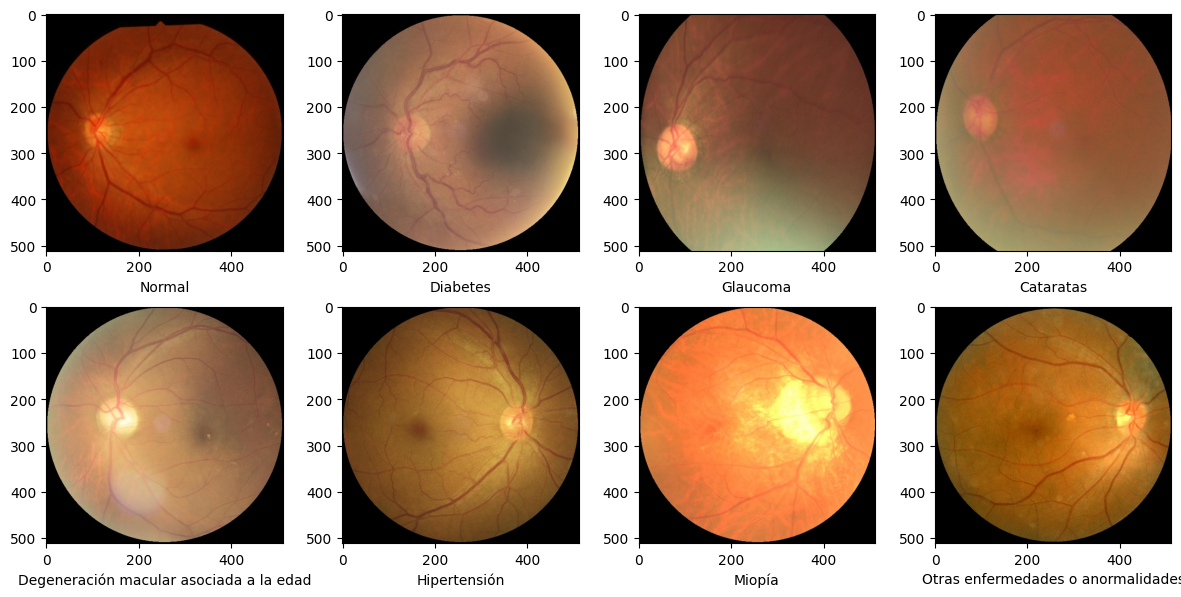

In [12]:
def get_samples_by_label(dataset, target_label):
    filtered_indices = [
        i for i, (data, label) in enumerate(dataset) if np.array_equal(label, target_label)
    ]
    return filtered_indices

def get_random_sample_by_label(dataset, target_label):
    filtered_indices = get_samples_by_label(dataset, target_label)
    random_index = random.choice(filtered_indices)
    return dataset[random_index]

def map_target_to_label(y):
    y_argmax = torch.argmax(y)
    if y_argmax == 0:
        return 'Normal'
    elif y_argmax == 1:
        return 'Diabetes'
    elif y_argmax == 2:
        return 'Glaucoma'
    elif y_argmax == 3:
        return 'Cataratas'
    elif y_argmax == 4:
        return 'Degeneración macular asociada a la edad'
    elif y_argmax == 5:
        return 'Hipertensión'
    elif y_argmax == 6:
        return 'Miopía'
    elif y_argmax == 7:
        return 'Otras enfermedades o anormalidades'
    else:
        raise Exception('Target desconocido')

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
idx = 0
for i in range(2):
    for j in range(4):
        target_label = np.zeros(8)
        target_label[idx] = 1.0
        idx += 1
        img, label = get_random_sample_by_label(dataset, target_label)
        ax[i][j].set_xlabel(map_target_to_label(torch.tensor(target_label)))
        ax[i][j].imshow(img.permute(1, 2, 0))
plt.tight_layout()
plt.show()

### Monstrar dataframe y cantidad de casos para cada clase

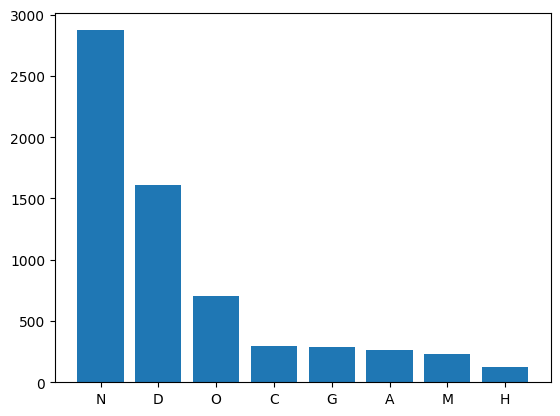

N: 2873
D: 1608
O: 708
C: 293
G: 284
A: 266
M: 232
H: 128


In [ ]:
full_df.head()

# Mostrar cantidad de casos para cada clase.

def clean_label(label):
    for c in ['[', ']', '\'']:
        label = str.replace(label, c, '')
    return label

labels_counts = full_df['labels'].value_counts()

plt.bar(
    labels_counts.keys().map(clean_label),
    labels_counts.values)

plt.show()

for k, v in labels_counts.items():
    print(f'{clean_label(k)}: {v}')

### Instanciar ResNet18, optmizer, loss y métrica

In [ ]:
weights = ResNet18_Weights.IMAGENET1K_V1
#transforms = weights.transforms()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet18_model = resnet18(weights=weights)

# Freezar los parámetros del modelo para realizar transfer learning.
for param in resnet18_model.parameters():
    param.requires_grad = False

# Sobreescribir la capa de salida para adaptar el modelo a un problema de
# clasificación de 8 clases.
num_targets = 8
last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=num_targets)
resnet18_model.to(device)

# Funciones de optimización y de pérdida.
optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss().to(device)

# Custom accuracy para la función de métrica.
def get_accuracy(y_hat, y):
    _, targets = torch.max(y, dim=1)
    _, preds = torch.max(y_hat, dim=1)
    corrects = (preds == targets).sum().item()
    return corrects / len(y)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 62.8MB/s]


### Funciones de entrenamiento y de gráfica de resultados

In [ ]:
def fit(nnet, train_dataloader, valid_dataloader, optimizer, loss_function, metric, epochs, device, verbose=False):
    train_loss_by_epoch = []
    train_accuracy_by_epoch = []
    valid_loss_by_epoch = []
    valid_accuracy_by_epoch = []

    for epoch in range(epochs):
        ############################################
        ## Entrenamiento
        ############################################
        nnet.train()

        n_train = len(train_dataloader.dataset)
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        epoch_y_hat = []
        epoch_y = []

        for i, data in enumerate(train_dataloader):
            # Batch de entrenamiento
            x_batch, y_batch = data
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device)

            # Forward
            y_batch_hat = nnet(x_batch)

            # Loss
            loss = loss_function(y_batch_hat, y_batch)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss y accuracy en batch
            epoch_loss = epoch_loss + loss.item()
            epoch_accuracy += metric(y_batch_hat, y_batch)

        # Loss y accuracy promedio en epoch
        epoch_loss = epoch_loss / n_train
        epoch_accuracy = epoch_accuracy / n_train
        train_loss_by_epoch.append(epoch_loss)
        train_accuracy_by_epoch.append(epoch_accuracy)

        ############################################
        ## Validación
        ############################################
        nnet.eval()

        n_valid = len(valid_dataloader.dataset)
        valid_epoch_loss = 0.0
        valid_epoch_accuracy = 0.0
        valid_epoch_y_hat = []
        valid_epoch_y = []

        for i, data in enumerate(valid_dataloader):
            # Batch de validación
            x_batch, y_batch = data
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device)

            # Forward
            y_batch_hat = nnet(x_batch)

            # Loss
            loss = loss_function(y_batch_hat, y_batch)

            # Loss y accuracy en batch
            valid_epoch_loss = valid_epoch_loss + loss.item()
            valid_epoch_accuracy += metric(y_batch_hat, y_batch)

        # Loss y accuracy promedio en epoch
        valid_epoch_loss = valid_epoch_loss / n_valid
        valid_epoch_accuracy = valid_epoch_accuracy / n_valid
        valid_loss_by_epoch.append(valid_epoch_loss)
        valid_accuracy_by_epoch.append(valid_epoch_accuracy)

        ############################################
        ## Impresión de resultados por epoch
        ############################################
        if verbose and epoch % 5 == 0:
            print(f' Epoch {epoch} | ' \
                f'Train/Valid loss: {epoch_loss:.3f} / {valid_epoch_loss:.3f} | ' \
                f'Train/Valid accuracy: {epoch_accuracy:.3f} / {valid_epoch_accuracy:.3f}')

    return train_loss_by_epoch, train_accuracy_by_epoch, valid_loss_by_epoch, valid_accuracy_by_epoch

def plot_results(train_loss_by_epoch, valid_loss_by_epoch, train_accuracy_by_epoch, valid_accuracy_by_epoch):
    fig, ax= plt.subplots(1, 2, figsize=(16, 5))
    ax[0].plot(train_loss_by_epoch, label='Train loss')
    ax[0].plot(valid_loss_by_epoch, label='Validation loss')
    ax[0].legend()
    ax[0].set_title('Loss by epoch')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Cross Entropy')

    ax[1].plot(train_accuracy_by_epoch, label='Train accuracy')
    ax[1].plot(valid_accuracy_by_epoch, label='Validation accuracy')
    ax[1].legend()
    ax[1].set_title('Accuracy by epoch')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')

    plt.show()

### Entrenamiento

In [ ]:
(train_loss_by_epoch,
 train_accuracy_by_epoch,
 valid_loss_by_epoch,
 valid_accuracy_by_epoch) = fit(
    resnet18_model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss,
    get_accuracy,
    epochs=50,
    device=device,
    verbose=True)

 Epoch 0 | Train/Valid loss: 0.046 / 0.042 | Train/Valid accuracy: 0.015 / 0.016
 Epoch 5 | Train/Valid loss: 0.037 / 0.038 | Train/Valid accuracy: 0.018 / 0.017
 Epoch 10 | Train/Valid loss: 0.035 / 0.037 | Train/Valid accuracy: 0.018 / 0.017
 Epoch 15 | Train/Valid loss: 0.034 / 0.038 | Train/Valid accuracy: 0.018 / 0.016
 Epoch 20 | Train/Valid loss: 0.034 / 0.038 | Train/Valid accuracy: 0.019 / 0.018
 Epoch 25 | Train/Valid loss: 0.032 / 0.036 | Train/Valid accuracy: 0.019 / 0.018
 Epoch 30 | Train/Valid loss: 0.032 / 0.038 | Train/Valid accuracy: 0.019 / 0.018
 Epoch 35 | Train/Valid loss: 0.032 / 0.037 | Train/Valid accuracy: 0.019 / 0.018
 Epoch 40 | Train/Valid loss: 0.031 / 0.039 | Train/Valid accuracy: 0.019 / 0.018
 Epoch 45 | Train/Valid loss: 0.031 / 0.037 | Train/Valid accuracy: 0.019 / 0.018


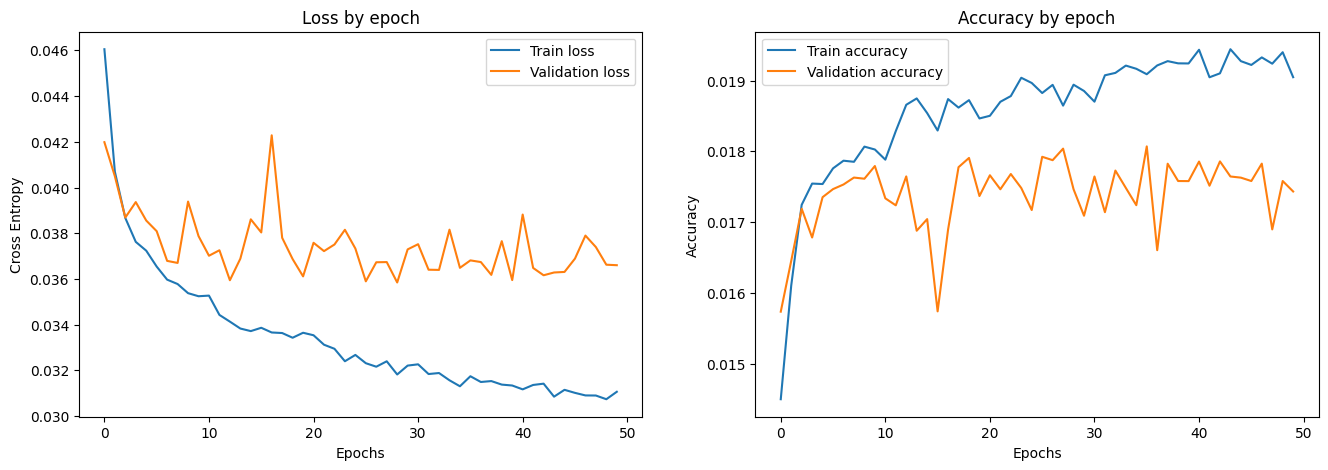

In [ ]:
plot_results(
    train_loss_by_epoch,
    valid_loss_by_epoch,
    train_accuracy_by_epoch,
    valid_accuracy_by_epoch)

### Realizar algunas predicciones

In [ ]:
# Se realizan 30 predicciones con el modelo y se compara con los
# respectivos valores esperados.

predictions_dataloader = DataLoader(test_dataset, batch_size=1)
resnet18_model.eval()

for i, data in enumerate(predictions_dataloader):
    x, y = data
    x = x.to(device).float()
    y = y.to(device)

    print(f'El valor esperado es \"{map_target_to_label(y)}\"')
    print(f'El valor obtenido por el modelo es \"{map_target_to_label(resnet18_model(x))}\"\n')

    if i == 30:
        break

El valor esperado es "Otras enfermedades o anormalidades"
El valor obtenido por el modelo es "Otras enfermedades o anormalidades"

El valor esperado es "Otras enfermedades o anormalidades"
El valor obtenido por el modelo es "Diabletes"

El valor esperado es "Cataratas"
El valor obtenido por el modelo es "Cataratas"

El valor esperado es "Diabletes"
El valor obtenido por el modelo es "Diabletes"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Miopía"
El valor obtenido por el modelo es "Miopía"

El valor esperado es "Diabletes"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Diabletes"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Otras enfermedades o anormalidades"
El valor obtenido por el modelo es "Otras enfermedades o anormalidades"

El valor esperado es "Diabletes"
El valor obtenido por el modelo es "Otras enfermedades o